# Model Analysis
Using various analysis techniques to analyze the patterns that the Random Forest model picked up in the data

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from Data_Prep import data_pipeline
print('setup complete')

setup complete


In [11]:
pokemon_model = load('Pokemon_Model.joblib')
pokemon_model

RandomForestClassifier(class_weight={0: 1, 1: 1}, max_depth=100,
                       max_features=10, max_leaf_nodes=20, max_samples=200,
                       n_estimators=60)

In [12]:
pokemon_df = pd.read_csv('Natdex_Data.csv')
X, y, scaler = data_pipeline(pokemon_df, drop_prevos=False, full_data=True, get_scaler=True)
predict_df = pd.concat([X, y], axis=1)

In [13]:
scale_columns = ['hp', 'atk', 'physdef', 'spatk', 'spdef', 'speed', 'bst']
partial_df = scaler.inverse_transform(predict_df[scale_columns])

### Permutation

In [14]:
import eli5
from eli5.sklearn import PermutationImportance

In [15]:
perm = PermutationImportance(pokemon_model).fit(X, y)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.0792 ± 0.0063,bst
0.0156 ± 0.0033,speed
0.0098 ± 0.0030,spatk
0.0094 ± 0.0031,isLegend
0.0043 ± 0.0038,atk
0.0033 ± 0.0007,steel
0.0031 ± 0.0023,physdef
0.0027 ± 0.0020,spdef
0.0017 ± 0.0000,fire
0.0015 ± 0.0007,ground


As we saw in the EDA, bst seems to be a hugely important feature, despite what many pokemon purists may have you think. Interestingly enough, speed follows immediately after. Even with the many good defensive pokemon with low speed, it still ends up being a very important factor. After that, the model used isLegend, which is not really something that directly affects a pokemon or not, but rather some classification that goes on top of the pokemon. The datapoint obviously helps the model predict, but it won't help any competitive player play the game.

Now is where it gets interesting. Beyond speed, it seems that special attack is the next most important stat. It's common knowledge for competitive pokemon players that special attacking is slightly better than physical attacking, so this checks out. It's followed pretty closely by attack, though.

Another interesting thing to note is how steel is the most important type, while dragon is near the bottom. This goes agaist the EDA, where we found that the largest proportion of viable pokemon per type is in the dragon type

However, aside from bst, none of these columns are particularly particularly strong. In addition, many of the type columns failed to do anything meaningful. Perhaps the next step could be to reduce the dimensionality of the data, even if that means getting rid of all of the type columns.

### Partial Dependence

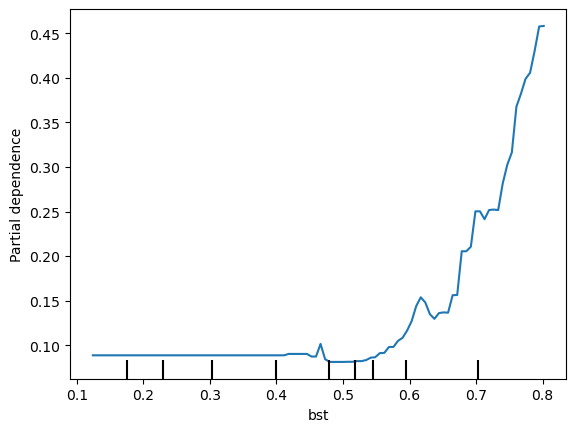

In [16]:
from sklearn.inspection import PartialDependenceDisplay

disp1 = PartialDependenceDisplay.from_estimator(pokemon_model, X, ['bst'])
plt.show()

Although the scale on the bottom isn't accurately reflective of the actual scaling of bst, it's still interpretable if you remember that the scaling is from 0 to 1, which reflects a bst from 175 to 780. Therefore, it can be seen that progressively higher and higher bsts mean more and more importance to the model, undoubtedly because it means its more and more likely to be viable

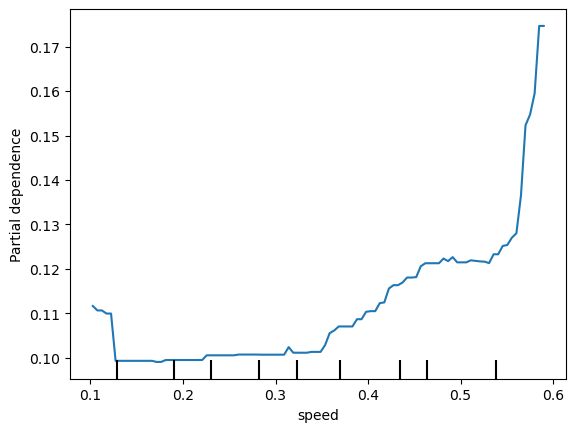

In [17]:
disp2 = PartialDependenceDisplay.from_estimator(pokemon_model, X, ['speed'])

The scale goes from 5 to 200

Its interesting to note the high partial dependence for very very low speeds. This means that low speed is an important trait in determining the viability. While this could lead to less viability, there are several good defensive pokemon that have very low speed. It's likely that these pokemon contributed to that importance too

There's also the steady, almost negative exponential rise over the course of the speed increasing from around 0.3 (scaled) to 0.5 (scaled). Evidently, speed is really good up until a certain point, where it flattens out or even dips a little bit. The incredibly sharp spike at the end is likely overfitting to the very small amount of pokemon with speeds that high.

### Shapley Value Analysis

note: 10.3% of the total dataset is viable, meaning a given pokemon in the dataset has a 10.3% chance of being viable

In [18]:
import shap

#example pokemon: Necrozma-Dusk-Mane (viable)

explainer = shap.TreeExplainer(pokemon_model)

shap_values = explainer.shap_values(X.loc[1168])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X.loc[1168])

The given choice is a pokemon that is pretty clearly viable. It seems as though even Necrozma-Dusk-mane is a steel type, that didn't play much into the model's decision. What was the most clear was the bst, followed by the attack. 

In [19]:
shap_values = explainer.shap_values(X.loc[747])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X.loc[747])

This example is toxapex, a non-legendary that is a premier defensive pokemon. This is where we see the flaws in our model that is inherent to its data. Toxapex is a very min-maxed pokemon--It's very good at being defensive and bad at pretty much everything else. That means it doesn't have the high bst and high attackings stats of many of the other viable pokemon. Because the model doesn't have access to its other attributes like its great movepool, great ability, and great matchup against metagame threats, the model ends up being confident that it's unviable even though it is viable

In [20]:
pokemon_df[pokemon_df.name.str.contains("Raichu")]

,name,type1,type2,ability1,ability2,hiddenability,hp,atk,physdef,spatk,spdef,speed,bst,alternate,isLegend,isFinal,tier,isViable
25,Raichu,electric,NaN,Static,Lightning Rod,NaN,60,90,55,90,80,110,485,0,0,1,RU,0
1003,Raichu-Alola,electric,psychic,Surge Surfer,NaN,NaN,60,85,50,95,85,110,485,1,0,1,RU,0


In [21]:
shap_values = explainer.shap_values(X.loc[1003])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X.loc[1003])

And finally, here's Alolan Raichu. The model is very confident that Alolan Raichu is terrible, and correctly so. Interestingly, it focuses in on the special attack as a downside, even though that's one of alolan raichu's best stats.

What the model does miss, though, is Raichu's situational usage, which the model's probability of 0.01 does not reflect. Raichu's ability Surge Surfer, paired with its speed, the move Rising Voltage, and the prominence of the pokemon Tapu Koko lead it to be situationally useful in being super fast and hitting very hard with rising voltage. Such a connection is simply impossible for the model to make with this kind of data.

### Shapley Summary Plots

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


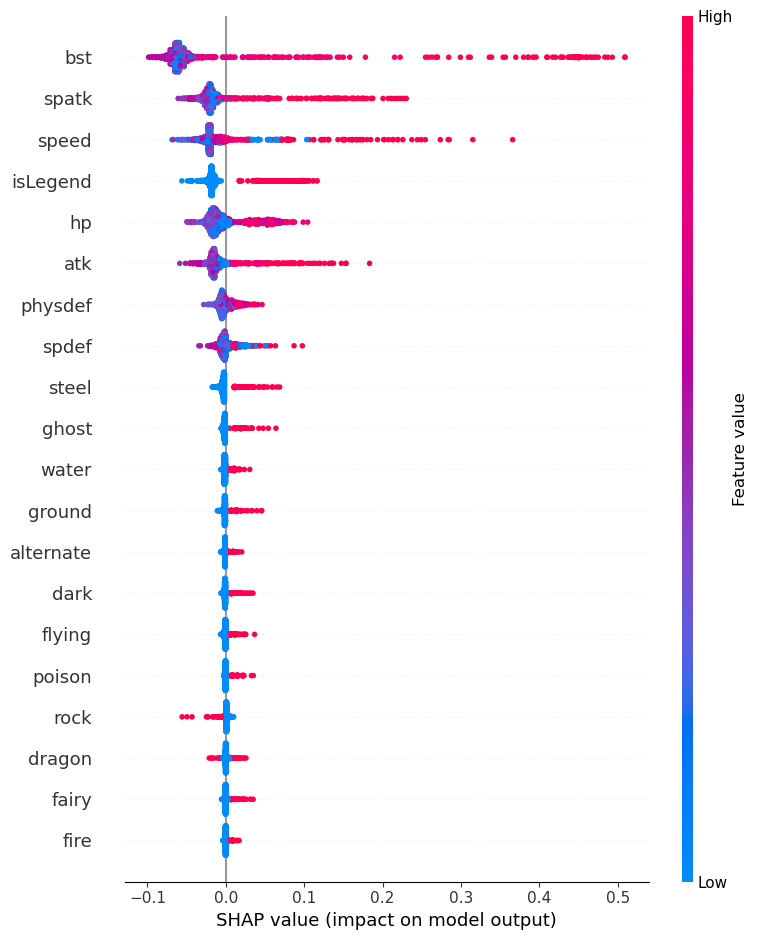

In [22]:
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values[1], X)

There's a lot to dissect here.

First of all, the common theme is that of a positive correlation: low values of a stat tend to lead to a low prediction and low value to the model, while high values of the stat lead to much much higher prediction and much higher value to the model.

Even then, it's not that simple. Even for many of the binary data, the spread of the shapley values is pretty varied--for example, rock has a pretty big range for its negative shapley values, even though its only comes in values of "0" or "1". This suggests that the model sees additional patterns between these features and other features.

While we could interpret the shapley values by looking at where they most increase the model's prediction, we can also see how low values can decrease the model's prediction. For example, a low BST seems almost like a dead end for a pokemon, since it not only gets points off from the model in the BST feature but also in the other stats with which BST is related with.

Finally, dragon is perhaps the most interesting feature here. A huge discovery in the EDA portion of the project was that the Dragon type had a significantly higher proportion of viable pokemon than any other type. However, there are some cases where a pokemon having the dragon type DECREASED its probability of being viable. That's very interesting.

### Shapley Dependence Contribution Plots

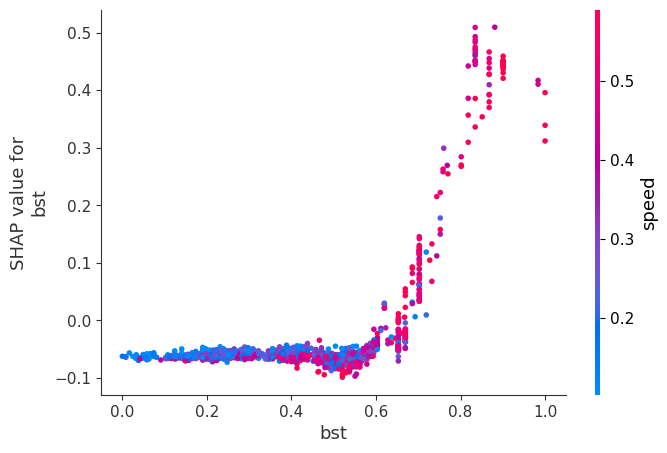

In [23]:
shap_values = explainer.shap_values(X)

shap.dependence_plot('bst', shap_values[1], X)

This is mostly what we expected, and what we saw with the partial dependence plot. The relationship with bst and the importance to the model is vagely exponential-esque, what with the low force at low bsts and very high force  at high bsts. However, there's one interesting feature here that I'd like to note.

Take note of the slight dip in at around 0.5 bst (again, it has been scaled, so this isn't an accurate numerical reflection). Obviously, the model is picking up on a wealth of pokemon that are around that bst and that are not good, leading it to be more confident in its assertion that they are not viable.

Look closer. Look at the hues of the dots in that area. Surprisingly, pokemon with higher speed stats at around this bst were predicted **lower** than if they had a lower speed stat. Despite speed's general positive relationship with viability, in this specific range of bsts, that relationship is actually reversed. This is likely because the model is picking up on the large amount of pokemon with a mediocre bst (thus, a bst around 0.5) who have all mediocre stats except speed. It's recognizing this pattern and acting on it.

### Conclusion

We first saw that bst was far and away the most important feature this model, which goes against much of the consensus in pokemon communities. Yes, bst does matter. However, looking deeper into the patterns that this model saw, including how much it valued these high bsts, led us to find some of the model's flaws. For example, this model does not have access to data about the pokemon's movepool, abilities, and competition, which are often 3 of the most important factors that contribute to a pokemon's viability.  However, this model still performed well at its predictions (if I remember correctly: somewhere in the ballpark of 90% accuracy on the dataset of only fully-evolved pokemon, which is a 7% improvement over baseline), which shows that despite this lack of data, it was still able to find meaningful connections and patterns. 

Although this machine learning model did perform relatively well, I have no doubt that a competitive pokemon player would still be able to analyze the viability of a pokemon at a higher level. Knowledge of the meta is very difficult for any machine learning model to understand because it requires data on every other pokemon. Where the human can easily narrow down their search and only focus on the important pokemon, the machine must mathematically consider every single pokemon. 